In [1]:
import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

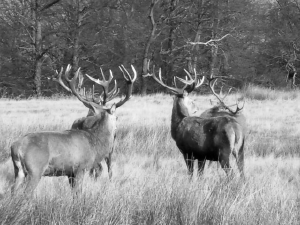

In [2]:
PIL.Image.open('./HoofedAnimals/org/9.png')

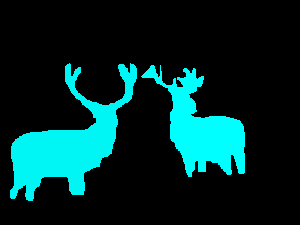

In [3]:
PIL.Image.open('./HoofedAnimals/mask/9_mask.png')

In [4]:
L = np.asarray([[*PIL.Image.open(f'./HoofedAnimals/org/{i}.png').size, i] for i in range(1, 201)])

In [5]:
unusable = [PIL.Image.open(f'./HoofedAnimals/org/{i}.png').size != PIL.Image.open(f'./HoofedAnimals/mask/{i}_mask.png').size for i in range(1, 201) ]

In [6]:
sum(unusable)

3

Certains masques n'ont pas la même taille que l'image d'origine. Par simplicité on va les éliminer de la base de données

## Preprocessing   
Les images sont de tailles variables:   
- padding : on complete avec des 0 pour avoir des images de meme taille

In [7]:
df = pd.DataFrame({'Width': L[:, 0], 'Height': L[:, 1], 'Area': L[:, 0] * L[:, 1], 'number': L[:, 2], 'unusable': unusable} )
df.drop(df.loc[df.unusable].index, inplace=True)
biggest = np.array(df[['Width', 'Height']].max())
print(f"The biggest image has shape {biggest}")
df.sort_values('Area')

The biggest image has shape [1353  910]


,Width,Height,Area,number,unusable
23,182,149,27118,24,False
44,200,147,29400,45,False
75,200,150,30000,76,False
49,200,150,30000,50,False
4,263,133,34979,5,False
...,...,...,...,...,...
172,1024,682,698368,173,False
164,1024,695,711680,165,False
193,1149,694,797406,194,False
170,1353,910,1231230,171,False


In [8]:
plt.style.use('ggplot')
df['Area'].plot.hist(bins=15)
print(f"The biggest image has shape {biggest}")

The biggest image has shape [1353  910]


Les images les plus grandes sont des outliers. Il serait couteux en memoire d'aggrandir toutes les images à leur taille. On limite la taille des images à 300 000 pixels

In [9]:
df.drop(df.loc[df.Area>=300000].index, inplace=True)
print(df.shape)
df.Area.plot.hist(bins=15)
biggest = np.array(df[['Height', 'Width']].max())
print(f"All image have at most shape {biggest}")

df.tail(20)

(174, 5)
All image have at most shape [447 654]


,Width,Height,Area,number,unusable
163,300,229,68700,164,False
166,500,333,166500,167,False
167,300,234,70200,168,False
168,300,216,64800,169,False
169,600,340,204000,170,False
173,568,426,241968,174,False
174,377,256,96512,175,False
175,572,447,255684,176,False
176,591,386,228126,177,False
180,428,270,115560,181,False


In [10]:
retained_id = (df.number).to_list() 
len(retained_id)

174

In [11]:
import torch
import torch.nn as nn

In [12]:
df.sort_index(inplace=True)
imgs, target_masks = [], []

for i in tqdm(retained_id):
    img = np.asarray(PIL.Image.open(f'./HoofedAnimals/org/{i}.png'))
    mask = np.asarray(PIL.Image.open(f'./HoofedAnimals/mask/{i}_mask.png'))
    size = np.array(img.shape)
    correction = (biggest - size).astype(int)
    pad = [correction[1] // 2, correction[1] - correction[1] // 2, correction[0] // 2, correction[0] - correction[0] // 2]
    img = torch.tensor(img)
    mask = torch.tensor(mask)
    
    img = nn.functional.pad(input=img, pad=pad)
    mask = nn.functional.pad(input=mask, pad=[0, 0, *pad]) #la fonction pad s'applique en premier aux dernière dimensions, ie la couleur pour mask, ce qui n'est pas souhaitable
    imgs.append(img.detach().numpy())
    target_masks.append(mask.detach().numpy())

  0%|          | 0/174 [00:00<?, ?it/s]

In [13]:
"""
images = torch.tensor(imgs)
target_masks = torch.tensor(target_masks)
"""

'\nimages = torch.tensor(imgs)\ntarget_masks = torch.tensor(target_masks)\n'

On a 174 images de taille 447 * 654

In [14]:
from utils import load_data

images, masks = load_data()

100%|███████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 197.92it/s]


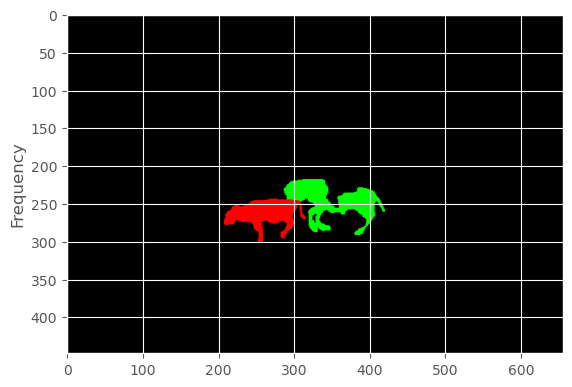

In [15]:
from utils import get_mask_per_type

target_masks = get_mask_per_type(masks)
plt.imshow(masks[0])
plt.show()

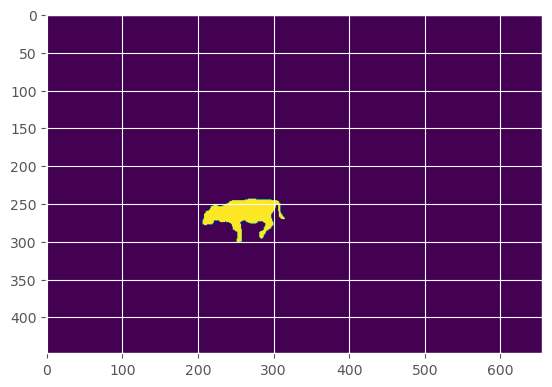

In [16]:
plt.imshow(target_masks[0][0])
plt.show()

In [17]:
from utils import masks_to_color_img
print(target_masks.shape[0])
masks2 = masks_to_color_img(target_masks[0]) 

174


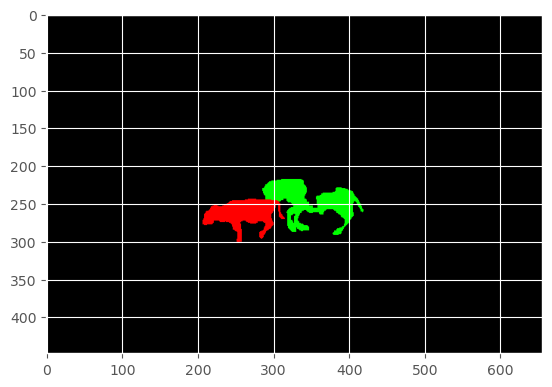

In [18]:
plt.imshow(masks2)
plt.show()

In [19]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred
    target = target  

    intersection = (pred * target).sum(axis=2).sum(axis=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(axis=2).sum(axis=2) + target.sum(axis=2).sum(axis=2) + smooth)))
    
    return loss.mean()

In [20]:
dice_loss(target_masks*0, target_masks)

0.2154778334816143